In [1]:
import matplotlib.pyplot as plt
import numpy as np
from cascadoc.blocks.concentrated_blocks.fun_block import FunBlock, ON_T, ON_S
from cascadoc.blocks.distributed_blocks.hyp_block import HypBlock

In [2]:
G11_true = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G22_true = lambda t: - (np.sin(t)) / (np.cos(t) - 4* np.sin(t))

x0 = lambda s: 0
y0 = lambda s: (3*s+1)/(2*(s+1))

x_an = lambda s, t: 2*(s**2+1)*np.sin(t)
y_an = lambda s, t: (3*s+1)/(2*(s+1))*np.cos(t)
T = [0, 0.2]
S = [0, 1]
C = [1,2]

B11 = lambda s, t: -2*s
B12 = lambda s, t: 4/3*s**2
B21 = lambda s, t: - (3*s+1)/(4*(s**2+1)*(s+1))
B22 = lambda s, t: 4/((s+1)*(3*s+1))



F1 = lambda s, t: 4*s**3*np.sin(t)+2*np.cos(t)+4*s**2*np.cos(t)/(3*(s+1))
F2 = lambda s, t: 0


s0, s1 = S
t0, t1 =T
c1, c2 = C
h=0.052


hyp = HypBlock("hyp", S0=s0, S1=s1, T0=t0, T1=t1, C1=c1, C2=c2, h=h, m=None)

In [3]:
hyp_mesh = hyp.get_mesh()

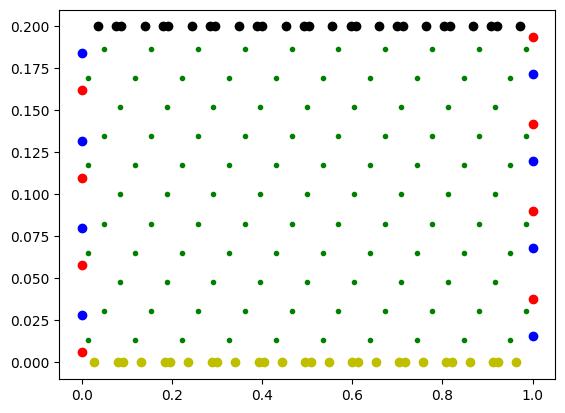

In [4]:
import math
eps = 0.000001

def is_int(i):
    return abs(round(i)-i) < eps

left_x = []
left_y = []
right_x = []
right_y = []
start_node = []
end_node = []

сenter_node = []
for node in hyp_mesh:
    i, j = node['ind']
    if node['t'] == t0:
        start_node.append(node)
    elif node['s'] == s0:
        
        if is_int(j):
            left_x.append(node)
        elif is_int(i):
            left_y.append(node)
        else:
            print(i, j)
    elif node['s'] == s1:
        if is_int(j):
            right_x.append(node)
        elif is_int(i):
            right_y.append(node)
        else:
            print(i, j)

    elif node['t'] == t1:
        end_node.append(node)
    else:
        сenter_node.append(node)
        
    

for n in left_x:
    n['type'] = 'left_x'
    plt.scatter(n['s'], n['t'], color='b')

for n in left_y:
    n['type'] = 'left_y'
    plt.scatter(n['s'], n['t'], color='r')

for n in right_x:
    n['type'] = 'right_x'
    plt.scatter(n['s'], n['t'], color='b')

for n in right_y:
    n['type'] = 'right_y'
    plt.scatter(n['s'], n['t'], color='r')

for n in start_node:
    n['type'] = 'start_node' 
    plt.scatter(n['s'], n['t'], color='y')

for n in end_node:
    n['type'] = 'end_node'
    plt.scatter(n['s'], n['t'], color='k')

for n in сenter_node:
    n['type'] = 'center'
    plt.scatter(n['s'], n['t'], color='g', marker='.')

In [5]:
hyp_mesh.sort(key=lambda n: n['t'])

In [6]:
mesh = [(n['t'], int(n['ind'][0])) for n in left_y]
mesh.sort(key=lambda x: x[0])
mesh
left = FunBlock("left", type_block=ON_T, fun =lambda t: y_an(s0, t), mesh = {i:m for m, i in mesh } , other_coord=s0)


mesh = [(n['t'], int(n['ind'][0])) for n in right_x]
mesh.sort(key=lambda x: x[0])
mesh
right = FunBlock("right", type_block=ON_T, fun =lambda t: x_an(s1, t), mesh = {i:m for m, i in mesh } , other_coord=s1)

In [28]:
from typing import Tuple
def center_solve(s:float, t:float,
                    sl:float, tl:float, xl:float, yl:float, hl:float, 
                    sr:float, tr:float, xr:float, yr:float, hr:float) -> Tuple[float, float]:
                
    A = [[1 - hr/2*B11(s, t), -hr/2*B12(s, t)],
         [-hl/2*B21(s, t), 1-hl/2*B22(s, t)]]
    b = [xr + hr/2*(B11(sr, tr)*xr+B12(sr, tr)*yr + F1(s, t) + F1(sr, tr)),
         yl + hl/2*(B21(sl, tl)*xl+B22(sl, tl)*yl + F2(s, t) + F2(sl, tl))]
    return np.linalg.solve(A, b)

def solver(mesh):
    for n in mesh:
        if n['type'] == 'start_node':
            val = [x0(n['s']), y0(n['s'])]
            hyp.add_index_val(n['ind'], val)
            n['x'] = val
        elif n['type'] == 'left_y':
            f = left(coord=n['t'])
            if not n['ind'] in hyp.rez:
                hyp.add_index_val(n['ind'], [None, f])
            else:
                hyp.rez[n['ind']][1] = f
            n['x'] = [None, f]
        elif n['type'] == 'right_x':
            f = right(coord=n['t'])
            if not n['ind'] in hyp.rez:
                hyp.add_index_val(n['ind'], [f, None])
            else:
                hyp.rez[n['ind']][0] = f
            n['x'] = [f, None]
        # elif n['type'] == 'center':
        #     # Проблема получения индексов (или вот этих необходимых расчетных элементов)
        #     # Нужен интерфейс, который бы позволил делать шаг назад вдоль характеристики 
        #     # (при этом если эта граница, то и позволял с ней работать)
        #     i, j = n['ind']
        #     li = i-1
        #     rj = j+1
        #     print(hyp.rez[(li, j)])
        #     print(hyp.rez[(i, rj)])
        #     # n['x'] = center_solve(n['s']m n['t'], )

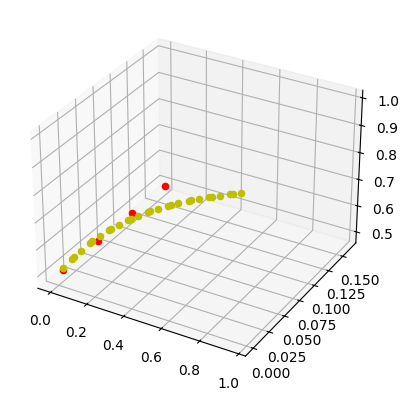

In [32]:
import matplotlib.pyplot as plt
fun_ = 1


import numpy as np
solver(hyp_mesh)
ax = plt.figure().add_subplot(projection='3d')
for n in start_node:
    ax.scatter(n['s'], n['t'], zs=n['x'][fun_], color='y')
# for n in left_x:
#     ax.scatter(n['s'], n['t'], zs=n['x'][fun_], color='y')
for n in left_y:
    ax.scatter(n['s'], n['t'], zs=n['x'][fun_], color='r')

# for n in right_x:
#     ax.scatter(n['s'], n['t'], zs=n['x'][fun_], color='b')
